<a href="https://colab.research.google.com/github/DonErnesto/masterclassSFI_2021/blob/main/notebooks/BitcoinSupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anti-Money Laundering with Supervised Classification

**Introduction**


The purpose of this Jupyter notebook is to make you familiar with several common supervised ML models, and to guide you through some essential steps when developing an ML model: hyperparameter tuning, model comparison and selection. 

Note that there are two types of cells in this notebook: Markdown cells (that contain text, like this one), and Code cells (that execute some code, like the next cell). 

By clicking the Play button on a cell, we execute a code cell. Lines that start with a "#" are comments, and not executed. 

Your input is required whenever there is a Question (in that case: write in the Markdown cell) or whenever you find some 'xxxxx' in the code cell (in this case, some code needs to be fixed or completed).


The data we will be using was taken from Kaggle: https://www.kaggle.com/ellipticco/elliptic-data-set 
and describes blockchain transactions, some of which are flagged as "illicit" (i.e., relating to illegal activity), others as "licit" or "unknown" (unknown being the majority, with about 80%). We got rid of the unknown labels for simplicity. The authors give as examples of illicit categories: "scams, malware, terrorist organizations, ransomware, Ponzi schemes, etc."

We start by downloading the data we will be training on, which has already been splitted into "X" (features) and "y" (labels).


In [9]:
## Data import from Github
import os
force_download = False
if force_download or not os.path.exists('X_train_supervised.csv.zip'): # then probably nothing was downloaded yet
    !curl -O https://raw.githubusercontent.com/DonErnesto/masterclassSFI_2021/main/ml_utils.py
    !curl -O https://raw.githubusercontent.com/DonErnesto/masterclassSFI_2021/main/data/X_train_supervised.csv.zip
    !curl -O https://raw.githubusercontent.com/DonErnesto/masterclassSFI_2021/main/data/y_train_supervised.csv.zip
    !curl -O https://raw.githubusercontent.com/DonErnesto/masterclassSFI_2021/main/data/X_test_supervised.csv.zip
    !curl -O https://raw.githubusercontent.com/DonErnesto/masterclassSFI_2021/main/data/y_test_supervised.csv.zip
    

We will be using pandas for data handling, and scikit-learn (sklearn) for supervised machine learning algorithms. 

In [10]:
# Package imports
import warnings
warnings.filterwarnings("ignore")
import pandas as pd # data I/O and manipulation
import numpy as np # numeric operations
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from ml_utils import grouped_boxplot_gridsearch, plot_conditional_distribution


Next, we will load the data in a so-called DataFrame (a pandas object), and inspect it by plotting the N-top rows

In [11]:
X_train = pd.read_csv('X_train_supervised.csv.zip')
X_test = pd.read_csv('X_test_supervised.csv.zip')
y_train = pd.read_csv('y_train_supervised.csv.zip')['class']
# .head() returns the first n (per default 5) rows of a DataFrame
X_train.head() 

,txId,Time step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,local_feat_8,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,agg_feat_72
0,232438397,1,0.163100,1.9640,-0.6465,12.41000,-0.06370,9.78000,12.41400,-0.1637,...,-0.5770,-0.614,0.2411,0.2415,1.07300,0.08550,-0.13110,0.67770,-0.1206,-0.1198
1,232029206,1,-0.005028,0.5790,-0.0914,4.38000,-0.06370,4.66800,0.85100,-0.1637,...,-0.5770,-0.614,0.2411,0.2415,0.60400,0.00863,-0.13110,0.33330,-0.1206,-0.1198
2,232344069,1,-0.147800,-0.1847,-1.2010,-0.12195,-0.04388,-0.11300,-0.06158,-0.1380,...,-0.5770,-0.614,0.2411,0.2415,0.01828,-0.08746,-0.13110,-0.09753,-0.1206,-0.1198
3,27553029,1,-0.151400,-0.1847,-1.2010,-0.12195,-0.04388,-0.11300,-0.06158,-0.1415,...,-0.5396,-0.582,-0.9790,-0.9785,0.01828,-0.08746,-0.13110,-0.09753,-0.1206,-0.1198
4,3881097,1,-0.172400,-0.1847,-1.2010,0.02810,-0.04388,-0.02914,0.24270,-0.1637,...,-0.5770,-0.601,0.2411,0.2415,0.01828,-0.06824,-0.08466,-0.05444,-1.7610,-1.7610


In [12]:
# Remove unwanted feature txId
X_train = X_train.drop(columns=['txId', 'Time step'])
X_test = X_test.drop(columns=['txId', 'Time step'])

**Further documentation on this dataset:**

From the Kaggle-website ( https://www.kaggle.com/ellipticco/elliptic-data-set ): "There are 166 features associated with each node. Due to intellectual property issues, we cannot provide an exact description of all the features in the dataset. There is a time step associated to each node, representing a measure of the time when a transaction was broadcasted to the Bitcoin network. ...

The first 94 features represent local information about the transaction – including the time step described above, number of inputs/outputs, transaction fee, output volume and aggregated figures such as average BTC received (spent) by the inputs/outputs and average number of incoming (outgoing) transactions associated with the inputs/outputs. The remaining 72 features are aggregated features, obtained using transaction information one-hop backward/forward from the center node - giving the maximum, minimum, standard deviation and correlation coefficients of the neighbour transactions for the same information data (number of inputs/outputs, transaction fee, etc.)."

Finally, and perhaps most relevant, the labels have been generated by a "heuristics-based reasoning process", as can be read in the article by Weber et al. (https://arxiv.org/pdf/1908.02591.pdf):

"For example, a higher number of inputs and the reuse of the same address is commonly associated with higher address-clustering, which results in a degrade of anonymity for the entity signing the transaction. On the other hand, consolidating funds controlled by multiple addresses in one single transaction provides benefits in terms of transaction costs (fee). It follows that entities eschewing anonymity-preserving measures for large volumes of user requests are likely to be licit (e.g. exchanges). In contrast, illicit activity may tend to favor transactions with a lower number of inputs to reduce". 

This essentially means that the labels were generated by hand-crafted rules. It is thus possible, that these rules may be reconstructed by the model through proxy-features, and that a higher-than-realistic score is achieved. 



In [13]:
print('Shape of training data:', X_train.shape, '\n')
print('Label counts:', '\n', y_train.value_counts(normalize=True), '\n')
print(f'Test data size (fraction of total): {len(X_test)/(len(X_train) + len(X_test)):.2%} ')

Shape of training data: (33441, 165) 

Label counts: 
 0    0.888849
1    0.111151
Name: class, dtype: float64 

Test data size (fraction of total): 28.18% 


There are 33.4k data points, of which 11% is a positive (which is quite a large fraction in a financial crime context). 

## Case-study: Decision Tree classifier

In [14]:
# First we import the classes we want to use 
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [15]:
?DecisionTreeClassifier

In [16]:
# Then we instantiate the DecisionTreeClassifier and define the parameter space we want to explore
dtc = DecisionTreeClassifier(random_state=3) #Initialize with whatever parameters you want to

# we will vary the maximum depth of the tree, and the minimum required number of samples to make a split
param_grid = {'max_depth': [2, 5, 10, 20]} #Note the dictionary notation

In [17]:
# We make use of the GridSearchCV estimator that does the scanning of the hyper-parameters for us,
# in a k-Fold cross-validation loop
grid_dtc = GridSearchCV(dtc, param_grid, cv=10, scoring='roc_auc', 
                        return_train_score=True) #NB: uses StratifiedKFold when cv=int

# Finally, we fit the GridSearchCV estimator to our training data, using the .fit() method
_ = grid_dtc.fit(X_train, y_train)

We use grouped_boxplot_gridsearch (a self-made helper function) to show how classifier performance is affected by the various hyperparameter settings. 

Note that the boxplots show:
- The median ("mid-point"), 
- a box spanning the first and third quartile, 
- and whiskers that extend to the median +/- 1.5 InterQuartile Range (IQR) or the lowest/highest point. Points beyond the median +/- 1.5 IQR are considered outliers and plotted explicitly

<div>
<img src="https://matplotlib.org/stable/_images/boxplot_explanation.png" width="600">
</div>

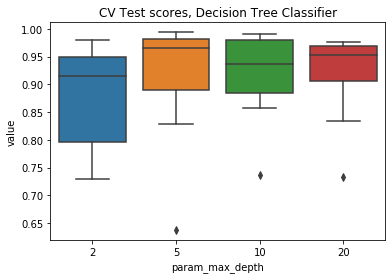

In [18]:
df = grouped_boxplot_gridsearch(grid_dtc, parameter_names=['max_depth'])
_ = plt.title('CV Test scores, Decision Tree Classifier')

Note how trees can always fit the training data perfectly (as long as there are no identical X's with different y's), given that they can grow large enough. This becomes apparent in the training scores (the scores on the training data itself, rather than on the validation set). 

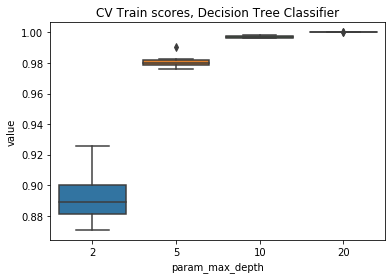

In [19]:
df = grouped_boxplot_gridsearch(grid_dtc, parameter_names=['max_depth' ], train_scores=True)
_ = plt.title('CV Train scores, Decision Tree Classifier')

In [20]:
grid_dtc.estimator

DecisionTreeClassifier(random_state=3)

Finally, let's visualize a tree. Let's make a simple tree, with max_depth=2

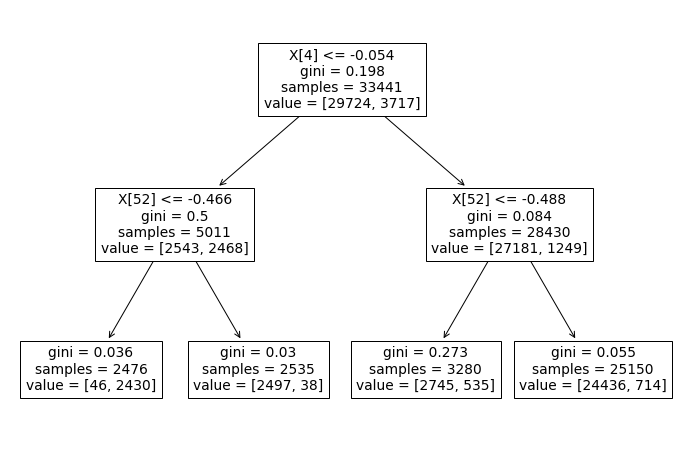

In [21]:
demo_tree = DecisionTreeClassifier(max_depth=2, random_state=1)
demo_tree.fit(X_train, y_train)
fig, ax = plt.subplots(1,1, figsize=(12, 8))
_ = plot_tree(demo_tree, ax=ax)

Even with the simple Decision Tree Classifier, ROC-AUC close to 0.90 are feasible judging by the cross-validation scores. The variance is however quite high, so the final test score could disappoint us. 


## Break-out session

- Go the sub-section within `Model and hyper-parameter selection with cross-validation` belonging to your model and run the cells 
- For more accurate results you may increase `cv` to 5 (Neural Network) or 10 (others)
 
- Answer the following questions:
    - Do you see any signs of overfitting? (i.e. much better performance on the training than on the validation data)
    - What can you say about the bias and variance of the model?
    - What hyper-parameters help to regularize the model? In what direction?
    - Which set of hyper-parameter values would you choose, and which one is chosen by the GridSearchCV object?
- Go to the section `Evaluation on test data`, and evaluate the .best_estimator_ object within the fitted GridSearchCV object. This is the estimator with the highest mean cross-validation test metric (we have chosen ROC-AUC). 
    - What AUC do you get? Is it as expected based on your cross-validation results? 



## Model and hyper-parameter selection with cross-validation

### Naive Bayes classifier

The Naive Bayes classifier is a rather simple yet powerful classifier, that has been used successfully in for instance spam filters. Here we will use a classifier that assumes a Gaussian distribution of its features, the Gaussian Naive Bayes classifier.  

In [22]:
from sklearn.naive_bayes import GaussianNB

In [23]:
?GaussianNB

In [24]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('nb', GaussianNB())
])
param_grid = {'nb__var_smoothing': np.logspace(-12, -3, num=4)} #Note the dictionary notation
nb = GaussianNB()

In [25]:
grid_nb = GridSearchCV(pipeline, param_grid, cv=10, scoring='roc_auc', return_train_score=True) #NB: uses StratifiedKFold when cv=int
_ = grid_nb.fit(X_train, y_train)

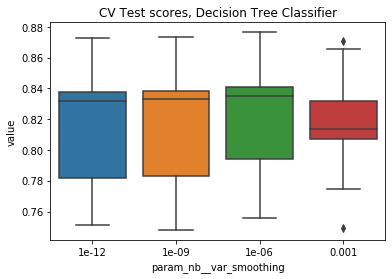

In [26]:
df = grouped_boxplot_gridsearch(grid_nb, parameter_names=['nb__var_smoothing', ])
_ = plt.title('CV Test scores, Decision Tree Classifier')

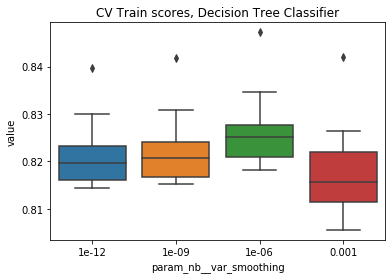

In [27]:
df = grouped_boxplot_gridsearch(grid_nb, parameter_names=['nb__var_smoothing', ], train_scores=True)
_ = plt.title('CV Train scores, Decision Tree Classifier')

### Logistic Regression

Logistic Regression is the classification-counterpart of Linear Least Squares for regression. Similar to linear regression, we can impose a penalty on larger coefficient values to prevent overfitting. This is called regularization. 

Too large a penalty (small C-value in the sklearn model) will lead to stable but sub-optimal performance (underfitting), too small a penalty may result in overfitting, especially when the number of features (columns) is high and the number of samples is low. When doing logistic regression, it is important to determine the optimal regularization strength in a cross-validation cycle. 

It is important that we scale the data before fitting the model when doing regularization. The correct way is to make scaling a part of a cross-validation pipeline, which is done using the Pipeline class of sklearn. 
The Pipeline object will behave just as a single classifier, having .fit() and .predict() methods. 

**Question:** Why do you think the scaling is important when we regularize the model by penalizing the coefficients?

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
?LogisticRegression

In [30]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(solver='saga', n_jobs=-1, random_state=10))
])
# define the parameter grid, preceding the argument name with "lr__" when it applies to the LogisticRegression
param_grid = {'lr__C': np.logspace(-5, -1, num=5), 
              #'lr__penalty': ['l1', 'l2']
             } 
grid_lr = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', return_train_score=True)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=10,
                                                           solver='saga'))]),
             param_grid={'lr__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])},
             return_train_score=True, scoring='roc_auc')

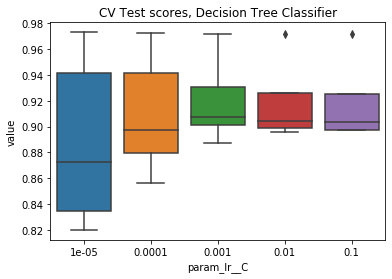

In [31]:
df = grouped_boxplot_gridsearch(grid_lr, parameter_names=['lr__C', ])
_ = plt.title('CV Test scores, Decision Tree Classifier')

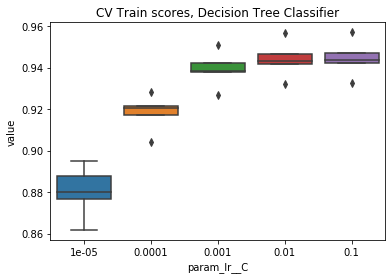

In [32]:
df = grouped_boxplot_gridsearch(grid_lr, parameter_names=['lr__C', ], train_scores=True)
_ = plt.title('CV Train scores, Decision Tree Classifier')

In [33]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.978178,1.325766,0.020442,0.002820,1e-05,{'lr__C': 1e-05},0.941374,0.972937,0.872448,0.820042,...,0.888262,0.059639,5,0.876648,0.861738,0.880225,0.887752,0.894885,0.880250,0.011191
1,5.696555,0.246630,0.016952,0.000602,0.0001,{'lr__C': 0.0001},0.941639,0.972368,0.897701,0.856566,...,0.909647,0.041950,4,0.917223,0.904150,0.921456,0.920504,0.928084,0.918283,0.007899
2,5.726794,0.272346,0.020052,0.006401,0.001,{'lr__C': 0.001},0.930860,0.971867,0.907834,0.887619,...,0.919869,0.029528,1,0.938602,0.926798,0.942323,0.938146,0.950731,0.939320,0.007719
3,6.250744,0.377661,0.021099,0.005185,0.01,{'lr__C': 0.01},0.925806,0.971906,0.904659,0.896225,...,0.919484,0.028198,2,0.943208,0.932193,0.946557,0.941986,0.956600,0.944109,0.007866
4,6.059136,0.400732,0.017851,0.002768,0.1,{'lr__C': 0.1},0.924877,0.971901,0.903792,0.897047,...,0.918963,0.028361,3,0.943644,0.932755,0.946892,0.942308,0.957077,0.944535,0.007841


### Random Forest

Random Forest Classifiers typically perform quite well over a wide range of parameters. The main parameter to tune is the depth of the individual trees ('max_depth'), which determines the model complexity. Typically, when the number of trees ('n_estimators') is chosen large enough (say, 100 or more), Random Forest classifiers typically do not suffer from overfitting. This is because the classifier is an ensemble of many tree classifiers ("bagging"), which reduces the variance of the predictions. 

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
?RandomForestClassifier

In [36]:
param_grid = {'max_depth': [2, 5, 10, 20], 'n_estimators':[10, 100]}
rfc = RandomForestClassifier(random_state=7) 

grid_rfc = GridSearchCV(rfc, param_grid, cv=5, scoring='roc_auc', return_train_score=True) 
_ = grid_rfc.fit(X_train, y_train)

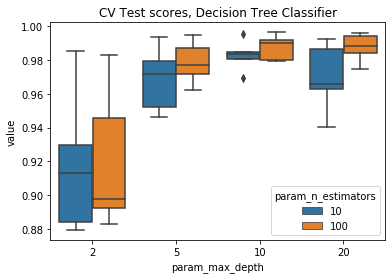

In [37]:
df = grouped_boxplot_gridsearch(grid_rfc, parameter_names=['max_depth', 'n_estimators'])
_ = plt.title('CV Test scores, Decision Tree Classifier')

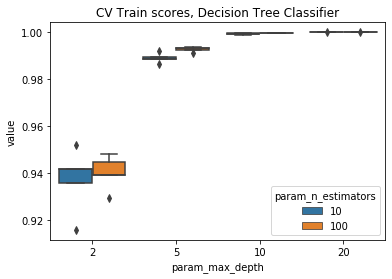

In [38]:
df = grouped_boxplot_gridsearch(grid_rfc, parameter_names=['max_depth', 'n_estimators'], train_scores=True)
_ = plt.title('CV Train scores, Decision Tree Classifier')

### Gradient boosted Trees

Gradient boosted trees share some similarities with Random Forests, in that they are an ensemble of trees. Whereas a Random Forest classifier consists of trees grown individually, Gradient Boosting generates trees that successively address misclassifications of the previous trees. Although scikit-learn does have a Gradient Boosting implementation it is advised to use LightGBM, a very performant implementation in terms of speed and accuracy. 

In [39]:
# !pip install lightgbm
from sklearn.ensemble import GradientBoostingClassifier #scikit-learn implementation. Not advised
from lightgbm import LGBMClassifier #roughly 2 orders of magnitude times faster than scikit-learn's implementation

In [40]:
clf_gb = LGBMClassifier()
#clf_gb = GradientBoostingClassifier()
param_grid = {
    'max_depth':[2, 5, 10], # sklearn and lightgbm implementation
    'num_iterations': [20, 50, 100], # lightgbm implementation
    }

grid_gb = GridSearchCV(estimator=clf_gb, param_grid=param_grid, cv=5, return_train_score=True, scoring='roc_auc')

In [41]:
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'max_depth': [2, 5, 10],
                         'num_iterations': [20, 50, 100]},
             return_train_score=True, scoring='roc_auc')

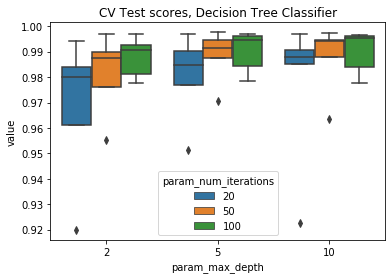

In [42]:
df = grouped_boxplot_gridsearch(grid_gb, parameter_names=['max_depth', 'num_iterations' ])
_ = plt.title('CV Test scores, Decision Tree Classifier')

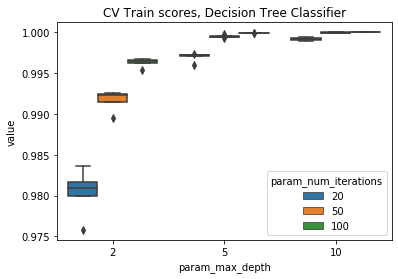

In [43]:
df = grouped_boxplot_gridsearch(grid_gb, parameter_names=['max_depth', 'num_iterations' ], train_scores=True)
_ = plt.title('CV Train scores, Decision Tree Classifier')

### Feedforward Neural Network

A feedforward neural network consists of consecutive layers of densely connected neurons. Their weights and biases need to be trained using the training data. We make use of Tensorflow for speed of calculation, and keras as a wrapper around Tensorflow to make the construction of the neural network easier. We add dropout, a fast and efficient regularization technique.  Because dropout randomly disables neurons, more training rounds ("epochs") are needed and also a somewhat wider network architecture to achieve good results. 

Neural networks typically have a lot of parameters that can be tuned: the number of layers, the width of the layers, the activation functions to be used, the batch size, the optimizer, and in our case also the drop-out rate. 

We will take the default mini-batch size of 32, and scan for optimal dropout rate and network width. 

In [44]:
from tensorflow import keras
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
KerasClassifier._estimator_type = 'classifier' #monkey-patch the class for plot_roc_curve

In [45]:
def build_clf(width=4, dropout_rate=0.0):
    ann = keras.models.Sequential()
    ann.add(keras.layers.InputLayer(input_shape=(X_train.shape[1],)))
    ann.add(keras.layers.Dense(units=width, activation='relu'))
    ann.add(keras.layers.Dropout(rate=dropout_rate, noise_shape=None, seed=None))
    ann.add(keras.layers.Dense(units=width, activation='relu'))
    ann.add(keras.layers.Dropout(rate=dropout_rate, noise_shape=None, seed=None))
    ann.add(keras.layers.Dense(units=1, activation='sigmoid'))
    ann.compile(optimizer='adam', loss='binary_crossentropy', 
                metrics=['accuracy', keras.metrics.AUC()])
    return ann

In [46]:
ann = KerasClassifier(build_fn=build_clf, epochs=3)
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('ann', ann)
])

In [47]:
params={'ann__width':[4, 6, 8],
        'ann__dropout_rate' : [0.0, 0.25],
        'ann__batch_size' : [32, ]
        }
grid_nn = GridSearchCV(estimator=pipeline, param_grid=params, cv=2, return_train_score=True, verbose=3, 
                       scoring='roc_auc')
# now fit the dataset to the GridSearchCV object. 
_ = grid_nn.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Epoch 1/3
523/523 [==============================] - 2s 2ms/step - loss: 0.2866 - accuracy: 0.8886 - auc: 0.8231
Epoch 2/3
523/523 [==============================] - 1s 2ms/step - loss: 0.1693 - accuracy: 0.9261 - auc: 0.9576
Epoch 3/3
523/523 [==============================] - 1s 2ms/step - loss: 0.1251 - accuracy: 0.9639 - auc: 0.9723
[CV 1/2] END ann__batch_size=32, ann__dropout_rate=0.0, ann__width=4;, score=(train=0.980, test=0.947) total time=   4.8s
Epoch 1/3
523/523 [==============================] - 2s 2ms/step - loss: 0.2853 - accuracy: 0.9193 - auc_1: 0.9204
Epoch 2/3
523/523 [==============================] - 1s 2ms/step - loss: 0.1036 - accuracy: 0.9724 - auc_1: 0.9732
Epoch 3/3
523/523 [==============================] - 1s 2ms/step - loss: 0.0843 - accuracy: 0.9747 - auc_1: 0.9801
[CV 2/2] END ann__batch_size=32, ann__dropout_rate=0.0, ann__width=4;, score=(train=0.985, test=0.814) total time=   4.0s
Epoch 1/3
52

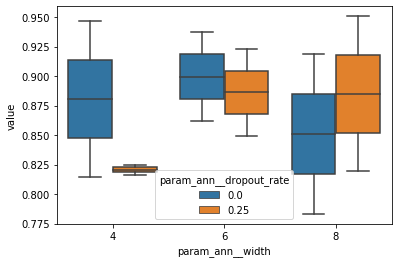

In [48]:
df = grouped_boxplot_gridsearch(grid_nn, parameter_names=['ann__width', 'ann__dropout_rate'])

In [49]:
?sns.boxplot

## Evaluation on test data

Having optimized the hyperparameters of our chosen classifier in a cross-validation, we will use this classifier to generate our predictions. 

The most straightforward option is to use .best_estimator() to access the best performing classifier 
according to the cross-validation. Per default (as determined by the `refit` argument to the gridsearch object) the entire training data is used to fit this best estimator. 

We will use predefined functions that plot various curves for us and also report classification metrics. 

In [50]:
# Load the test data. 
y_test = pd.read_csv('y_test_supervised.csv.zip')['class']

With `plot_conditional_distribution`, we can make conditional density plots, to visualize the degree of separation  between the positive and negative class by the classifier. 
Replace `grid_dtc` with your own trained GridsearchCV object (`grid_xx`) for evaluation.

The ROC-AUC test score: 0.741


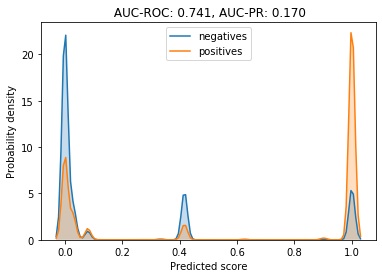

In [51]:
y_pred = grid_dtc.best_estimator_.predict_proba(X_test)[:, 1]
print(f'The ROC-AUC test score: {roc_auc_score(y_test, y_pred):.3f}')
_ = plot_conditional_distribution(y_test, y_pred, bw=0.01)

An even easier approach is to plot the ROC and  Precision-Recall curves using
`plot_roc_curve` and `plot_precision_recall_curve`.
Both functions require an estimator (we take our best one, stored in `.best_estimator_`), and the X_test and y_test data. See examples below. 

Replace `grid_dtc` with your own trained GridsearchCV object (`grid_xx`) for evaluation

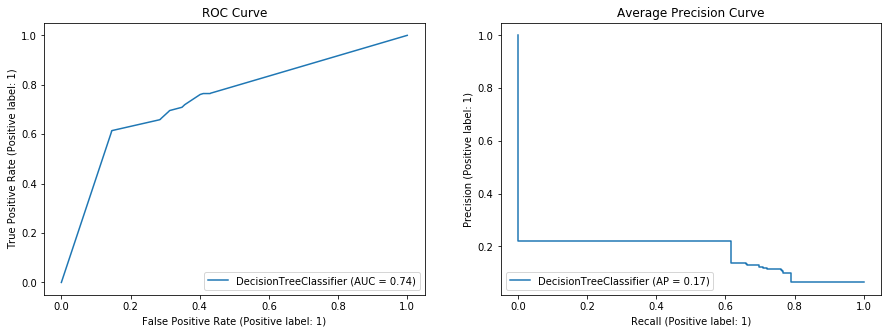

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
_ = plot_roc_curve(estimator=grid_dtc.best_estimator_, X=X_test, y=y_test, ax=axs[0])
_ = plot_precision_recall_curve(estimator=grid_dtc.best_estimator_, X=X_test, y=y_test, ax=axs[1])

_ = axs[0].set_title('ROC Curve')
_ = axs[1].set_title('Average Precision Curve')

## Comparison of all "best" estimators

        DecisionTreeClassifier. ROC-AUC test score:  0.741,   Average Precision test score:  0.170
                    GaussianNB. ROC-AUC test score:  0.801,   Average Precision test score:  0.149
            LogisticRegression. ROC-AUC test score:  0.861,   Average Precision test score:  0.373
        RandomForestClassifier. ROC-AUC test score:  0.922,   Average Precision test score:  0.762
                LGBMClassifier. ROC-AUC test score:  0.958,   Average Precision test score:  0.827
               KerasClassifier. ROC-AUC test score:  0.889,   Average Precision test score:  0.667


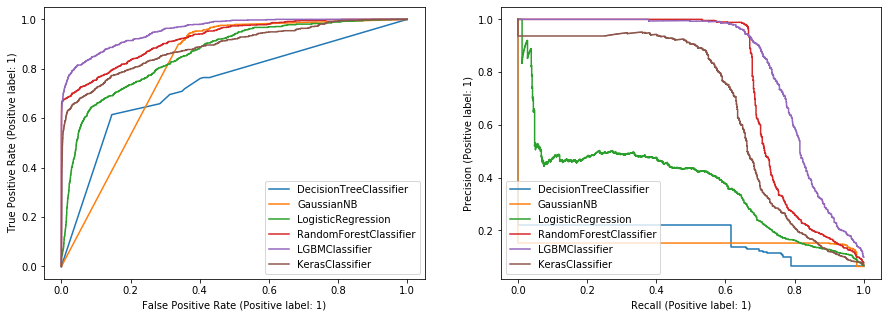

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for clf in [grid_dtc, grid_nb, grid_lr, grid_rfc, grid_gb, grid_nn]:
    label = (type(clf.estimator).__name__ if not type(clf.estimator).__name__ == 'Pipeline' 
        else type(clf.estimator[-1]).__name__)
    _ = plot_roc_curve(estimator=clf.best_estimator_, X=X_test, y=y_test, ax=axs[0], label=label)
    _ = plot_precision_recall_curve(estimator=clf.best_estimator_, X=X_test, y=y_test, ax=axs[1], label=label)
    y_pred = clf.best_estimator_.predict_proba(X_test)[:, 1]
    print(f'{label:>30}. ROC-AUC test score: {roc_auc_score(y_test, y_pred):>6.3f},   '\
         f'Average Precision test score: {average_precision_score(y_test, y_pred):>6.3f}')


# Final thoughts and observations

- Despite large variety in models and challenging theory, implementing an ML pipeline is straightforward an automatable (see also: AutoML)
- The challenges of an ML Project are not so much the machine learning itself, but rather:
    - setting up robust data and feature extraction pipelines
    - obtaining enough and high-quality labels
    - dealing with bias and concept-drift
    - governance, adoption and embedment in existing processes 
- The performance on the dataset used here is very high and not realistic (likely due to labeling heuristic, a common deficiency in open datasets)

